In [ ]:
#import and hyperparameters for data generation
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.util import random_noise

L = 32
N = 2000 # number of images

healthy_cells = 0.1 # blob fraction for healthy cells
pathological_cells = 0.3 # blob fraction for pathological cells



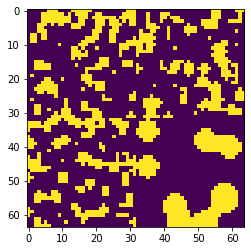

In [ ]:
#sample stacked image
x = data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3)
y = data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3)
x2 = data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3)
y2 = data.binary_blobs(length = L, blob_size_fraction = pathological_cells, n_dim = 2, volume_fraction = 0.3)
z = np.block([[x,y], [x2, y2]])
plt.imshow(z)

In [ ]:
def create_image(healthy=True):
  list0 = []
  list1 = []
  list2 = []
  list3 = []
  pathological_idx = 20
  if not healthy:
    pathological_idx = np.random.randint(0, 16)

  for i in range(16):
    if i == pathological_idx:
      if i % 4 == 0:
        list0.append(data.binary_blobs(length = L, blob_size_fraction = pathological_cells, n_dim = 2, volume_fraction = 0.3))
      elif i % 4 == 1:
        list1.append(data.binary_blobs(length = L, blob_size_fraction = pathological_cells, n_dim = 2, volume_fraction = 0.3))
      elif i % 4 == 2:
        list2.append(data.binary_blobs(length = L, blob_size_fraction = pathological_cells, n_dim = 2, volume_fraction = 0.3))
      elif i % 4 == 3:
        list3.append(data.binary_blobs(length = L, blob_size_fraction = pathological_cells, n_dim = 2, volume_fraction = 0.3))
    else:
      if i % 4 == 0:
        list0.append(data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3))
      elif i % 4 == 1:
        list1.append(data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3))
      elif i % 4 == 2:
        list2.append(data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3))
      elif i % 4 == 3:
        list3.append(data.binary_blobs(length = L, blob_size_fraction = healthy_cells, n_dim = 2, volume_fraction = 0.3))

  return np.block([list0, list1, list2, list3])




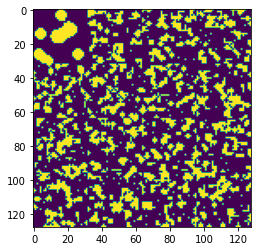

In [ ]:
x = create_image(False)
plt.imshow(x)

In [ ]:
labels = np.random.randint(2, size = N) #create binary labels, 0 = pathological, 1 = healthy

imgs = np.zeros((L*4, L*4, N))
for i in range(N):
  if labels[i] == 0:
    x = create_image(False)
  elif labels[i] == 1:
    x = create_image(True)
  
  imgs[:,:,i] = x

[0 0 1 0 0 1 0 1 1 0]


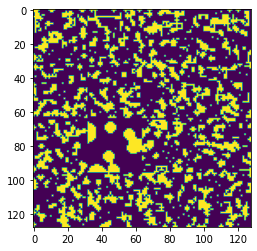

In [ ]:
plt.imshow(imgs[:,:,0])

print(labels[:10])

In [ ]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y=labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(2000, 128, 128, 1)

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 2
input_shape = (L*4, L*4, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

# Train model:
batch_size =64
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 57600)             0         
                                                                 
 dropout_2 (Dropout)         (None, 57600)            

In [ ]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.44723114371299744
Test accuracy: 0.7954545617103577
              precision    recall  f1-score   support

Pathological       0.77      0.82      0.79       320
     Healthy       0.82      0.78      0.80       340

    accuracy                           0.80       660
   macro avg       0.80      0.80      0.80       660
weighted avg       0.80      0.80      0.80       660



In [ ]:
#Code for Occlusion Mapping, slightly modified from
#https://gist.github.com/RaphaelMeudec/7985b0c5eb720a29021d52b0a0be549a

import numpy as np
import tensorflow as tf

grey_value = 0.5
# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = grey_value

    return patched_image

PATCH_SIZE = 32


img = X_test[np.where(y_test == 0)[0][0]]
img_class = y_test[np.where(y_test == 0)[0][0]]


NameError: ignored

In [ ]:
pred = model.predict(np.array([img]))[0]
print(pred)
print(y_test[:10])


[0.60406804 0.39593193]
[1 1 0 0 0 1 0 1 1 1]


In [ ]:
#apply non-overlapping sensitivity map
sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[img_class]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence

In [ ]:
#variation on the sensitivity map with overlapping patches
sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
step_size = 4
# Iterate the patch over the image
for top_left_x in range(0, img.shape[0] - PATCH_SIZE + 1, step_size):
    for top_left_y in range(0, img.shape[1] - PATCH_SIZE + 1, step_size):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[img_class]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = (sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,] + confidence)/2

In [ ]:
#create mean sensitivity map for all instances of a class
imgs = X_test[np.where(y_test == 1)]
imgs_class = 1

#apply non-overlapping sensitivity map
maps = np.zeros(imgs.shape[:3])
# Iterate the patch over the image
for img_idx in range(0, imgs.shape[0]):
  img = imgs[img_idx, :, :, :]
  sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
  for top_left_x in range(0, img.shape[0], PATCH_SIZE):
      for top_left_y in range(0, img.shape[1], PATCH_SIZE):
          patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
          predicted_classes = model.predict(np.array([patched_image]))[0]
          confidence = predicted_classes[img_class]
          
          # Save confidence for this specific patched image in map
          sensitivity_map[
              top_left_y:top_left_y + PATCH_SIZE,
              top_left_x:top_left_x + PATCH_SIZE,
          ] = confidence
  maps[img_idx, :, :] = sensitivity_map     

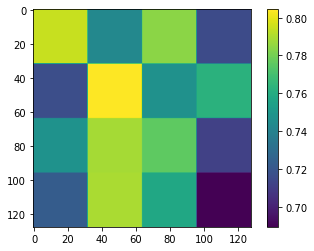

In [ ]:
mean_map = np.mean(maps, axis = 0)
plt.imshow(mean_map)
plt.colorbar()

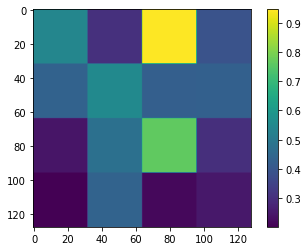

In [ ]:
plt.imshow(sensitivity_map)
plt.colorbar()

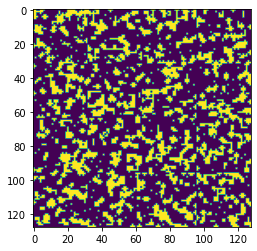

In [ ]:
plt.imshow(img.squeeze())

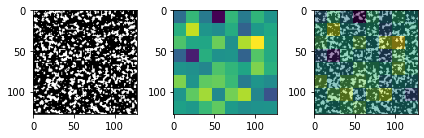

In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(img.squeeze(), cmap=plt.cm.gray)
ax[1].imshow(sensitivity_map)
ax[2].imshow(img.squeeze(), cmap=plt.cm.gray)
ax[2].imshow(sensitivity_map, alpha=0.5)
fig.tight_layout()

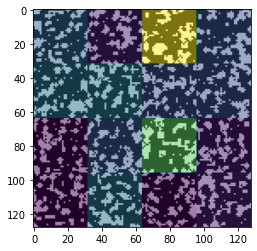

In [ ]:
plt.imshow(img.squeeze(), cmap=plt.cm.gray)
plt.imshow(sensitivity_map, alpha=0.5)